# Employee Status Prediction

This notebook implements binary classification models (SVM and ANN) to predict employee status (0=Active, 1=Left) based on various features.

## 1. Data Preprocessing

Perform comprehensive preprocessing on the given dataset containing various abnormalities including missing values, outliers, inconsistent formatting, and duplicates. Encode features where applicable, and split the data appropriately for modeling.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the dataset
df = pd.read_csv('Group-2 Data.csv')
print("Columns in dataset:", df.columns.tolist())
df.head()

Columns in dataset: ['employee_id', 'age', 'income', 'hours_worked', 'education', 'department', 'commute_distance', 'remote_work', 'satisfaction_score', 'project_count', 'hire_date', 'employee_status']


,employee_id,age,income,hours_worked,education,department,commute_distance,remote_work,satisfaction_score,project_count,hire_date,employee_status
0,5571,32.008182,6208.293542,15.319871,High School,Marketing,10.491144,0.0,4,7,12/13/2022,0
1,4742,-38.216785,79984.937900,67.789437,high school,IT,23.619443,0.0,3,5,2/5/2021,1
2,6438,110.156400,NaN,27.212829,High School,Sales,40.859652,0.0,5,6,8/7/2021,0
3,6723,28.961617,13261.956530,57.618563,H.S.,Sales,-1.087843,0.0,9,5,11/19/2023,0
4,9987,NaN,NaN,27.949207,masters,Sales,7.713179,0.0,9,6,8/6/2019,0


### 1.1 Data Exploration and Cleaning

In [7]:
# Check for duplicates
print(f"Duplicates: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Impute missing values
# For numerical columns, use median
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, use mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Handle negative values in numerical columns (like age, income, hours_worked, commute_distance)
for col in ['age', 'income', 'hours_worked', 'commute_distance']:
    if col in df.columns:
        df[col] = df[col].abs()

# Handle outliers (using IQR for age, income, hours_worked, commute_distance)
for col in ['age', 'income', 'hours_worked', 'commute_distance']:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

# Standardize education levels
education_map = {
    'B.S.': 'Bachelor', 'BACHELOR': 'Bachelor', 'Bachelor': 'Bachelor',
    'M.S.': 'Master', 'Master': 'Master', 'masters': 'Master',
    'H.S.': 'High School', 'High School': 'High School',
    'phd': 'PhD', 'PhD': 'PhD'
}
df['education'] = df['education'].map(education_map).fillna('Other')

df.head()

Duplicates: 166
Missing values:
 employee_id              0
age                      2
income                1521
hours_worked             0
education              985
department               1
commute_distance         1
remote_work              1
satisfaction_score       0
project_count            0
hire_date              453
employee_status          0
dtype: int64


/tmp/ipython-input-12397677.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-12397677.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,employee_id,age,income,hours_worked,education,department,commute_distance,remote_work,satisfaction_score,project_count,hire_date,employee_status
0,5571,32.008182,6208.293542,15.319871,High School,Marketing,10.491144,0.0,4,7,12/13/2022,0
1,4742,38.216785,74754.055761,67.789437,Other,IT,23.619443,0.0,3,5,2/5/2021,1
2,6438,64.509987,22381.360410,27.212829,High School,Sales,40.859652,0.0,5,6,8/7/2021,0
3,6723,28.961617,13261.956530,57.618563,High School,Sales,1.087843,0.0,9,5,11/19/2023,0
4,9987,35.653811,22381.360410,27.949207,Master,Sales,7.713179,0.0,9,6,8/6/2019,0


### 1.2 Feature Encoding and Splitting

In [8]:
# Encode categorical features
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])
df['department'] = le.fit_transform(df['department'])

# Drop non-numeric/unnecessary columns (like employee_id or hire_date)
df = df.drop(columns=['employee_id', 'hire_date'], errors='ignore')

# Split data
X = df.drop('employee_status', axis=1)
y = df['employee_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (8027, 9)
Testing set shape: (2007, 9)


## 2. Support Vector Machine (SVM)

Implement SVM for binary classification with GridSearchCV for hyperparameter tuning, exploring different kernels and regularization parameters. Report best parameters and evaluate model performance on test data.

In [10]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(probability=True), param_grid, refit=True, verbose=2, cv=3)
grid.fit(X_train, y_train)

print(f"Best Parameters: {grid.best_params_}")
svm_preds = grid.predict(X_test)
svm_probs = grid.predict_proba(X_test)[:, 1]

print("SVM Classification Report:")
print(classification_report(y_test, svm_preds))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  13.6s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   7.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   6.3s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   7.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.7s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   6.2s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   7.1s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   6.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   6.2s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   5.5s
[CV] END ...................C=0.1, gamma=auto, k

## 3. Artificial Neural Network (ANN)

Build a three-layer Artificial Neural Network using ReLU activation in the hidden layers and sigmoid activation in the output layer. Implement dropout regularization in each hidden layer. Train the model for 50 epochs, plot the training and validation accuracy/loss curves, and evaluate its performance on the test set. Display the complete model architecture summary.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,753 (10.75 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5548 - loss: 0.6922 - val_accuracy: 0.5859 - val_loss: 0.6768
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5719 - loss: 0.6803 - val_accuracy: 0.5915 - val_loss: 0.6739
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5964 - loss: 0.6726 - val_accuracy: 0.5959 - val_loss: 0.6737
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5920 - loss: 0.6723 - val_accuracy: 0.5946 - val_loss: 0.6722
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5892 - loss: 0.6734 - val_accuracy: 0.5984 - val_loss: 0.6716
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5920 - loss: 0.6738 - val_accuracy: 0.5953 - val_loss: 0.6715
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5816 - loss: 0.6762 - val_accuracy: 0.5903 - val_loss: 0.6723
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5872 - loss: 0.6709 - val_accuracy: 0.

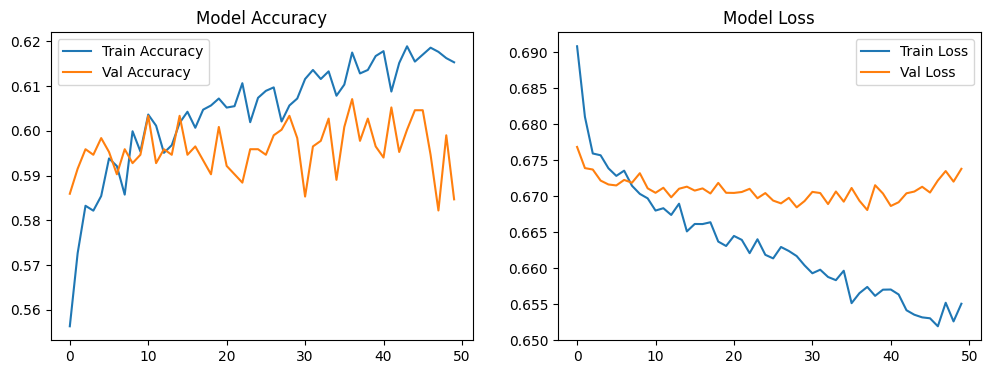

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
ANN Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.78      0.67      1098
           1       0.57      0.35      0.43       909

    accuracy                           0.59      2007
   macro avg       0.58      0.57      0.55      2007
weighted avg       0.58      0.59      0.56      2007



In [12]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

ann_probs = model.predict(X_test).flatten()
ann_preds = (ann_probs > 0.5).astype(int)

print("ANN Classification Report:")
print(classification_report(y_test, ann_preds))

## 4. Compare the Results

Compare SVM and ANN performance by generating classification reports, confusion matrices, and ROC curves.

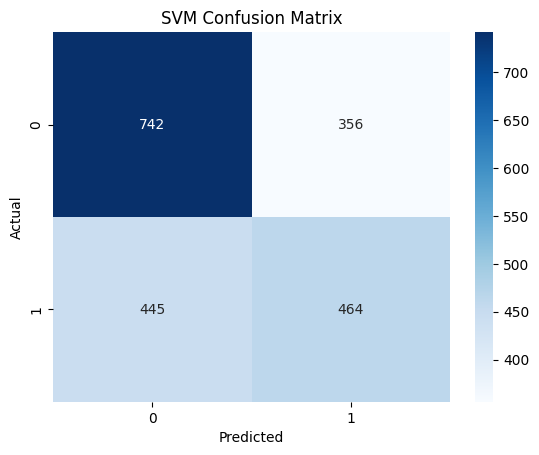

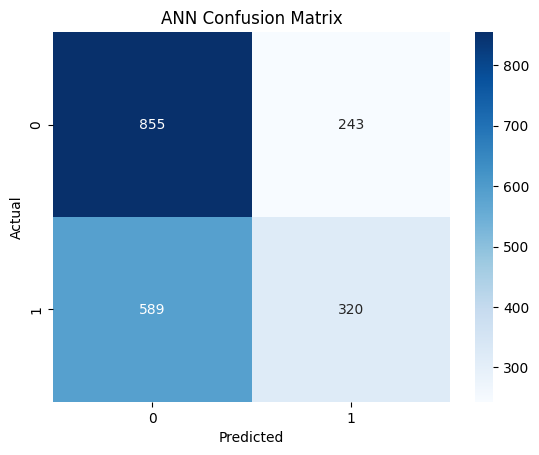

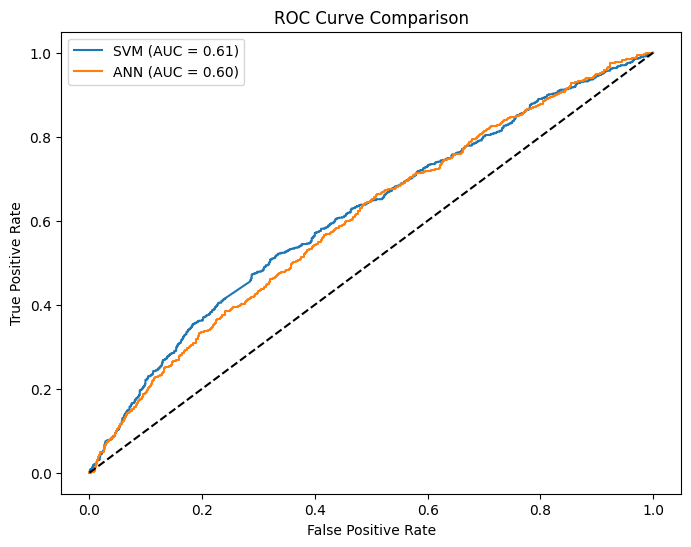

In [13]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, svm_preds, 'SVM Confusion Matrix')
plot_confusion_matrix(y_test, ann_preds, 'ANN Confusion Matrix')

# ROC Curves
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)
fpr_ann, tpr_ann, _ = roc_curve(y_test, ann_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc(fpr_svm, tpr_svm):.2f})')
plt.plot(fpr_ann, tpr_ann, label=f'ANN (AUC = {auc(fpr_ann, tpr_ann):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()